<a href="https://colab.research.google.com/github/nathanielmhld/Machine-Learning-Pipelines/blob/main/TextSwitch/SameWordTest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import numpy as np
from scipy import ndimage, misc
import matplotlib.pyplot as plt
import cv2
import string

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw


In [ ]:
serif ="/usr/share/fonts/truetype/liberation/LiberationSerif-Regular.ttf"
sanserif = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"

In [ ]:
#Helper functions

In [ ]:
def new_mesh(n):
    mr = n
    mc = n

    xx = np.arange(0, mr, 1)
    yy = np.arange(0, mc, 1)
    [Y, X] = np.meshgrid(xx, yy)
    ms = np.transpose(np.asarray([X.flatten('F'), Y.flatten('F')]), (1,0))

    perturbed_mesh = ms
    nv = np.random.randint(50) - 1
    for k in range(nv):
        #Choosing one vertex randomly
        vidx = np.random.randint(np.shape(ms)[0])
        vtex = ms[vidx, :]
        #Vector between all vertices and the selected one
        xv  = perturbed_mesh - vtex
        #Random movement 
        mv = (np.random.rand(1,2) - 0.5)*100
        hxv = np.zeros((np.shape(xv)[0], np.shape(xv)[1] +1) )
        hxv[:, :-1] = xv
        hmv = np.tile(np.append(mv, 0), (np.shape(xv)[0],1))
        d = np.cross(hxv, hmv)
        d = np.absolute(d[:, 2])
        d = d / (np.linalg.norm(mv, ord=2))
        wt = d


        curve_type = np.random.rand(1)
        if curve_type > 0.3:
            alpha = np.random.rand(1) * 50 + 50
            wt = alpha / (wt + alpha)
        else:
            alpha = np.random.rand(1) + 1
            wt = 1 - (wt / 100 )**alpha
        msmv = mv * np.expand_dims(wt, axis=1)
        perturbed_mesh = perturbed_mesh + msmv
        xs = perturbed_mesh[:, 0].reshape(n, n).astype(np.float32)
        ys = perturbed_mesh[:,1].reshape(n, n).astype(np.float32)
        return (xs, ys)

In [ ]:
def word_to_im(word):
    n = 150
    font = ImageFont.truetype(font=np.random.choice([serif,sanserif]),size=25)
    img=Image.new("RGBA", (100,100),(255,255,255))
    draw = ImageDraw.Draw(img)
    draw.text((0, 0),word,(0,0,0),font=font)
    draw = ImageDraw.Draw(img)
    img = cv2.copyMakeBorder(
    np.array(img, dtype=np.uint8), 
    50, 
    0, 
    50, 
    0, 
    borderType=cv2.BORDER_CONSTANT, 
    value=(255,255,255)
    )
    img = np.array(img, dtype=np.uint8)
    xs, ys = new_mesh(n)
    img = cv2.remap(img,xs, ys, cv2.INTER_CUBIC)
    return add_noise(img)

In [ ]:
def add_noise(img,overall=30,individual=5):
    return np.array(np.clip(
        img + np.random.normal(0,overall) + 
        np.random.normal(0,individual, size=img.shape),0,255), dtype=np.uint8)

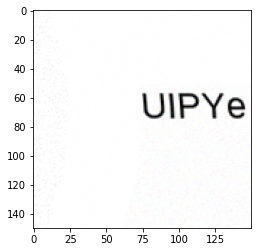

In [ ]:
#test the word generation
word = "".join(np.random.choice(list(string.printable[:63] + ' '), size=5))
plt.imshow(word_to_im(word))

In [ ]:
from tqdm import tqdm

In [ ]:
d = {}
for i in tqdm(range(100)):
    word = "".join(np.random.choice(list(string.printable[:63] + ' '), size=np.random.choice(range(2,6))))
    d[word] = []
    for j in range(100):
        try:
            d[word].append(word_to_im(word))
        except TypeError:
            pass

100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


In [ ]:
!mkdir images

In [ ]:
for i in tqdm(range(5000)):
    word_indexes = np.random.choice(list(d.keys()),2, replace=False)
    word_lists = [d[j] for j in word_indexes]
    first_indexes = np.random.choice(len(word_lists[0]),2)
    second_index = np.random.choice(len(word_lists[1]),1)[0]

    pair = np.array(word_lists[0])[first_indexes]
    
    im = Image.fromarray(np.concatenate(pair, axis=0))
    im.convert('RGB').save("images/T"+str(i).zfill(4) + ".jpg", "JPEG")

    pair = np.array([word_lists[0][first_indexes[0]], 
                     word_lists[1][second_index]])
    
    im = Image.fromarray(np.concatenate(pair, axis=0))
    im.convert('RGB').save("images/F"+str(i).zfill(4) + ".jpg", "JPEG")

100%|██████████| 5000/5000 [00:26<00:00, 190.43it/s]


In [ ]:
from fastai.vision import *

In [ ]:
files = get_image_files("images")

In [ ]:
def label_func(f): return str(f)[7] == 'T'

In [ ]:
dls = ImageDataBunch.from_name_func("", files, label_func)

In [ ]:
import torch

In [ ]:
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
from fastai.vision.models import resnet34

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
torch.cuda.empty_cache()

In [ ]:
learn.fit(9) 

epoch,train_loss,valid_loss,error_rate,time
0,0.805587,0.667555,0.394500,00:32
1,0.662672,0.617314,0.330500,00:32
2,0.590289,0.559730,0.289000,00:32
3,0.520474,0.525154,0.260500,00:32
4,0.466521,0.473712,0.219500,00:32
5,0.413300,0.437323,0.201000,00:32
6,0.394649,0.421280,0.187000,00:32
7,0.343067,0.418008,0.177000,00:32
8,0.304691,0.402404,0.166500,00:32


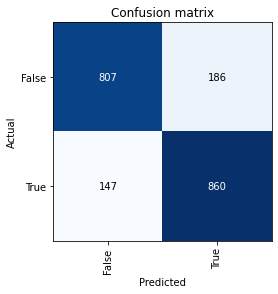

In [ ]:
#resnet34 seems to max out at about 20% error rate 
#resnet101 seems to max out at about 20% error rate
#resnet152 seems to max out at about 12% error rate
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
from google.colab import files as colabfiles
#colabfiles.download('sameword.pkl') 

In [ ]:
uploaded = colabfiles.upload()

Saving test.zip to test.zip


In [ ]:
%%capture
!unzip test.zip

In [ ]:
import os

In [ ]:
#resnet32 10 step : 72
#resnet101 10 step : 88
#resnet150 15 step : 72

correct = 0
for file in os.listdir("test"):
  preds = learn.predict(open_image("test/"+file))[2]
  if (file[0] == "T") == (preds[1] > .5).item():
    correct += 1
print(correct, " out of ",len(os.listdir("test")), " or ", int(100*correct/len(os.listdir("test"))),"%")

26  out of  36  or  72 %


In [ ]:
# On to stage 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
imsize = 64 #224 if torch.cuda.is_available() else 128  # use small size if no gpu



def image_loader(image_name, size=imsize):
    loader = transforms.Compose([
        transforms.Resize(size),  # scale imported image
        transforms.ToTensor()])  # transform it into a torch tensor
    
    image = Image.open(image_name)
    image = image.convert('RGB')
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [ ]:
uploaded = colabfiles.upload()

Saving date1.png to date1.png


In [ ]:
uploaded = colabfiles.upload()

Saving contentdate.png to contentdate.png


In [ ]:
#Ok, let's try something else. Maybe, MCMC?

In [ ]:
styleimage = Image.open("date1.png").resize((100,100))
contentimage = Image.open("contentdate.png")
contentimage = np.array(contentimage.convert('RGB').resize(styleimage.size))
styleimage = np.array(styleimage.convert('RGB'))

In [ ]:
test = Image.open("images/F0003.jpg")

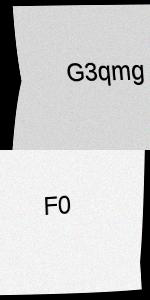

In [ ]:
test

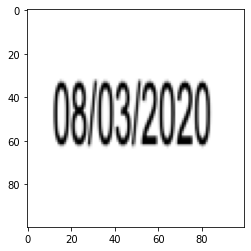

In [ ]:
plt.imshow(contentimage)

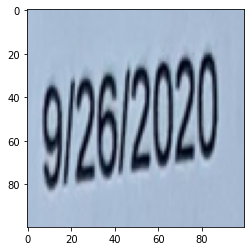

In [ ]:
plt.imshow(styleimage)

In [ ]:
get_loss(styleimage, contentimage)

0.9995951056480408

In [ ]:
from fastai.vision import Image as Fastai_image
import torchvision.transforms as T

In [ ]:
 def get_loss(new_image, contentimage):
  img = Image.fromarray(np.concatenate(np.array([new_image,contentimage]), axis=0))
  img_tensor = T.ToTensor()(img)
  return learn.predict(Fastai_image(img_tensor))[2][1].item()


In [ ]:
new_image = styleimage.copy()
max_likeness = get_loss(new_image, contentimage)

for i in range(10000):
  adjust = np.zeros(shape=new_image.shape)
  for j in range(10):
    random_indices = (np.random.choice(new_image.shape[0]),np.random.choice(new_image.shape[1]))
    adjust[random_indices] + np.random.choice([-255,255])
  test_image = np.array(np.clip(new_image + adjust,0,255), dtype=np.uint8)
  test_likeness = get_loss(test_image, contentimage)
  if i % 1000 == 0:
    print("Iteration ",i)
  if test_likeness > max_likeness:
    new_image = test_image
    max_likeness = test_likeness
    print("Improved")
  if test_likeness == max_likeness:
    new_image = test_image


  

Iteration  0
Iteration  1000
Iteration  2000
Iteration  3000
Iteration  4000
Iteration  5000
Iteration  6000
Iteration  7000
Iteration  8000
Iteration  9000


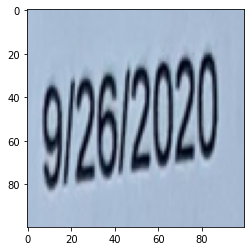

In [ ]:
plt.imshow(new_image)

In [ ]:
style_img = image_loader("contentdate.png")
content_img = image_loader("date1.png",size=style_img.size()[-2:])

In [ ]:
assert style_img.size() == content_img.size()

In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated



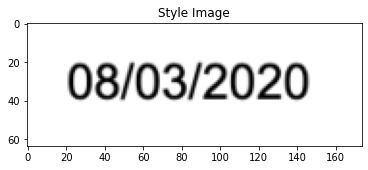

In [ ]:
plt.figure()
imshow(style_img, title='Style Image')

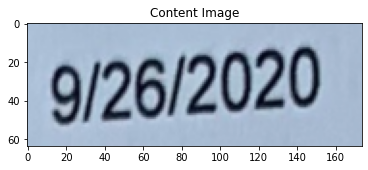

In [ ]:
plt.figure()
imshow(content_img, title='Content Image')

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [ ]:
topilimage = transforms.ToPILImage(mode='L')

In [ ]:
from PIL import Image as PImage
from fastai.vision import Image
import torchvision.transforms as T

#frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
#pil_im = PImage.fromarray(frame) 
#x = pil2tensor(pil_im ,np.float32)

In [ ]:
def style_loss_function(inp,targ):
  inp = inp.cpu()
  targ = targ.cpu()
  retval = 0
  for b in range(inp.shape[1]):
    thisinp = topilimage(inp[0][b])
    thistarg = topilimage(targ[0][b])
    thisinp = thisinp.convert('RGB').resize((150,150))
    thistarg = thistarg.convert('RGB').resize((150,150))
    thisinp = np.array(thisinp)
    thistarg = np.array(thistarg)
    img = PImage.fromarray(np.concatenate(np.array([thistarg,thisinp]), axis=0))
    img_tensor = T.ToTensor()(img)
    retval += learn.predict(Image(img_tensor))[2][0]
  
  return retval


In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = target_feature.detach()

    def forward(self, input):
        self.loss = style_loss_function(input, self.target)
        return input

In [ ]:
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [ ]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

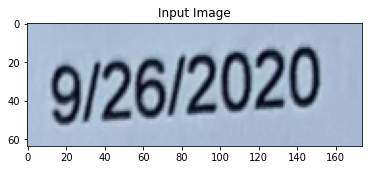

In [ ]:
input_img = content_img.clone()
#input_img = style_img.clone()
# if you want to use white noise instead uncomment the below line:
#input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    #optimizer = optim.LBFGS([input_img.requires_grad_()],lr=100)
    optimizer = optim.Adam([input_img.requires_grad_()], lr=0.01)
    return optimizer

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=100,
                       style_weight=1000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 1 == 0:
                imshow(input_img.data.clamp_(0, 1), title='Output Image')
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..


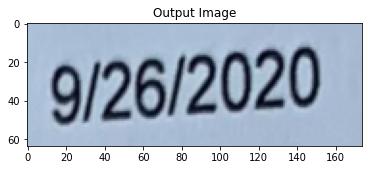

run [1]:
Style Loss : 737.358337 Content Loss: 0.000000



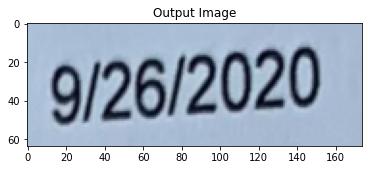

run [2]:
Style Loss : 737.358337 Content Loss: 0.000000



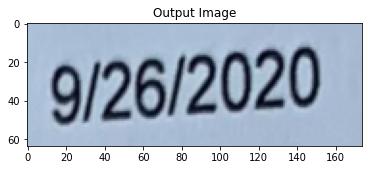

run [3]:
Style Loss : 737.358337 Content Loss: 0.000000



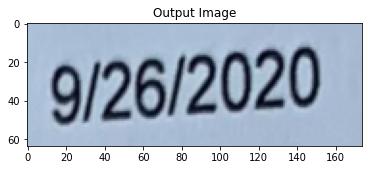

run [4]:
Style Loss : 737.358337 Content Loss: 0.000000



KeyboardInterrupt: ignored

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()